# Housing Price Prediction

The goal of this notebook is to predict the prices of houses in the famous 'Ames Housing dataset' available on kaggle : https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset

We will use Linear regression to do so.

## Summary

* [1. Dataset Exploration](#1)
    * [1.1 Summary Statistics](#1.1)
    * [1.2 Standardization](#1.2)
    * [1.3 Categorical Data](#1.3)
    * [1.4 Feature Relashionships](#1.4)
    * [1.5 Sale Price](#1.5)
  
* [2. Machine learning](#2)
    * [2.1 Linear Regression](#2.1)
    * [2.2 Feature Engineering](#2.2)
* [3. Conclusion and Feature Importance](#3)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import FuncFormatter

from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler

<a id='1'></a>
# <u> 1. Dataset Exploration

In [2]:
ames_df=pd.read_csv(r"AmesHousing.csv")

We take a first look at the data to explore possible missing data, datatypes, number of features, etc:

In [3]:
ames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

Drop ORDER and PID columns because they are identifiers

In [4]:
ames_df.drop(columns=["Order","PID"],inplace=True)

We display the total number of missing values per datatype and column:

In [5]:
for i in ["number","object"]:
    missing_df=ames_df.select_dtypes(i).isnull().sum()[ames_df.select_dtypes(i).isnull().sum()!=0].sort_values(ascending=False)
    print("\n"+str(len(missing_df))+ " " + i + "-type columns contain missing values:",missing_df,sep="\n\n")


11 number-type columns contain missing values:

Lot Frontage      490
Garage Yr Blt     159
Mas Vnr Area       23
Bsmt Full Bath      2
Bsmt Half Bath      2
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Garage Cars         1
Garage Area         1
dtype: int64

16 object-type columns contain missing values:

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Garage Finish      159
Garage Qual        159
Garage Cond        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Electrical           1
dtype: int64


First, we will deal with the columns with the highest number of missing data: Pool QC, Misc Feature, Alley and Fence.

Since each one has more missing data than quality data, we chose to delete each of the columns as we do not consider it appropriate to extrapolate the information from a small sample.

In [6]:
ames_df.drop(columns=["Pool QC", "Misc Feature", "Alley", "Fence"],axis=1,inplace=True)

Then, we will explore and clean the missing data from the "garage-" features:

In [7]:
aux=ames_df[[c for c in ames_df.columns if "Garage" in c]]
display(aux[aux.isnull()])

print("We will assume that if a house has a NaN value in the 'Garage Type', it indicates that the house has no garage.\n"+
      "Therefore, we will fill the categorical variables related to the garage with 'None' and the field 'Garage Yr Blt' with 0")

ames_df[['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']] = ames_df[['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']].fillna('None')
ames_df["Garage Yr Blt"]=ames_df["Garage Yr Blt"].fillna(0)

display(ames_df[['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond','Garage Yr Blt']])


,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2926,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2927,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2928,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will assume that if a house has a NaN value in the 'Garage Type', it indicates that the house has no garage.
Therefore, we will fill the categorical variables related to the garage with 'None' and the field 'Garage Yr Blt' with 0


,Garage Type,Garage Finish,Garage Qual,Garage Cond,Garage Yr Blt
0,Attchd,Fin,TA,TA,1960.0
1,Attchd,Unf,TA,TA,1961.0
2,Attchd,Unf,TA,TA,1958.0
3,Attchd,Fin,TA,TA,1968.0
4,Attchd,Fin,TA,TA,1997.0
...,...,...,...,...,...
2925,Detchd,Unf,TA,TA,1984.0
2926,Attchd,Unf,TA,TA,1983.0
2927,None,None,None,None,0.0
2928,Attchd,RFn,TA,TA,1975.0


We conduct an analogous analysis with the features regarding the Basement and replace with None and 0 in case there's no basement in the house

In [8]:
ames_df[['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']]=ames_df[['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']].fillna(0)
ames_df[['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']]=ames_df[['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']].fillna("None")

When we explore the features regarding Fireplace we see that the NaNs of the column "Fireplace Qu" happen when # of Fireplaces = 0, then we label suchs NaNs as 'None':

In [9]:
aux=ames_df[[c for c in ames_df.columns if "Fireplace" in c]]
display(aux[aux[["Fireplace Qu"]].isnull().any(axis=1)])

ames_df["Fireplace Qu"]=ames_df["Fireplace Qu"].fillna("None")

print("After handling missing data:")
ames_df[["Fireplaces","Fireplace Qu"]]

,Fireplaces,Fireplace Qu
1,0,NaN
2,0,NaN
6,0,NaN
7,0,NaN
11,0,NaN
...,...,...
2921,0,NaN
2922,0,NaN
2925,0,NaN
2926,0,NaN


After handling missing data:


,Fireplaces,Fireplace Qu
0,2,Gd
1,0,None
2,0,None
3,2,TA
4,1,TA
...,...,...
2925,0,None
2926,0,None
2927,0,None
2928,1,TA


Now we analyze the fields 'Mas Vnr Area' and 'Mas Vnr Type':

In [10]:
aux=ames_df[[c for c in ames_df.columns if "Mas Vnr" in c]]
aux[aux[["Mas Vnr Area"]].isnull().any(axis=1)]

display(aux)

print("If both columns ('Mas Vnr Area' and 'Mas Vnr Type') have NaN in the same rows then we can assume that the house doesn't have this condition and fill with None and 0")

idx=aux[aux[["Mas Vnr Area"]].isnull().any(axis=1)].index
ames_df.loc[idx,"Mas Vnr Area"]=ames_df.loc[idx,"Mas Vnr Area"].fillna(0)
ames_df.loc[idx,"Mas Vnr Type"]=ames_df.loc[idx,"Mas Vnr Type"].fillna("None")

aux=ames_df[[c for c in ames_df.columns if "Mas Vnr" in c]]
aux[aux[["Mas Vnr Area"]].isnull().any(axis=1)]
display(aux)

print("There are still some missing values of 'Mas Vnr Type', but since they are aprox 60% of the data we cannot use the other 40% to estimate the missing values, so we decided to labeled them as 'None'")

idx=aux[aux[["Mas Vnr Type"]].isnull().any(axis=1)].index
ames_df.loc[idx,"Mas Vnr Type"]=ames_df.loc[idx,"Mas Vnr Type"].fillna("None")

,Mas Vnr Type,Mas Vnr Area
0,Stone,112.0
1,NaN,0.0
2,BrkFace,108.0
3,NaN,0.0
4,NaN,0.0
...,...,...
2925,NaN,0.0
2926,NaN,0.0
2927,NaN,0.0
2928,NaN,0.0


If both columns ('Mas Vnr Area' and 'Mas Vnr Type') have NaN in the same rows then we can assume that the house doesn't have this condition and fill with None and 0


,Mas Vnr Type,Mas Vnr Area
0,Stone,112.0
1,NaN,0.0
2,BrkFace,108.0
3,NaN,0.0
4,NaN,0.0
...,...,...
2925,NaN,0.0
2926,NaN,0.0
2927,NaN,0.0
2928,NaN,0.0


There are still some missing values of 'Mas Vnr Type', but since they are aprox 60% of the data we cannot use the other 40% to estimate the missing values, so we decided to labeled them as 'None'


Handling "Lot Frontage" missing values:

In [11]:
ames_df["Lot Frontage"].describe()

count    2440.000000
mean       69.224590
std        23.365335
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

In [12]:
print("As the mean and the median are similar, we choose to replace the missing data with the mean")
ames_df["Lot Frontage"]=ames_df["Lot Frontage"].fillna(ames_df["Lot Frontage"].mean())

As the mean and the median are similar, we choose to replace the missing data with the mean


In [13]:
print("Finally, we will drop 1 row from Garage Cars, Garage Area and Electrical")

ames_df.dropna(inplace=True)

Finally, we will drop 1 row from Garage Cars, Garage Area and Electrical


<a id='1.1'></a>
## <u> 1.1 Summary Statistics

In [14]:
ames_df.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,...,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,57.375342,69.229867,10148.434426,6.095628,5.563183,1971.360997,1984.253757,101.165984,442.593579,49.739413,...,93.722336,47.565915,22.954918,2.594262,16.012978,2.244877,50.669740,6.217555,2007.790642,180810.808402
std,42.649902,21.325731,7882.680122,1.411218,1.111838,30.235707,20.861399,178.676009,455.664494,169.194874,...,126.395966,67.495008,64.064368,25.149828,56.104969,35.609292,566.536198,2.714675,1.316976,79911.692062
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,60.000000,7439.500000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,50.000000,69.224590,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,78.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,734.250000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


Because of the number of features, we will plot the histogram to better understand the behaviour of our dataset

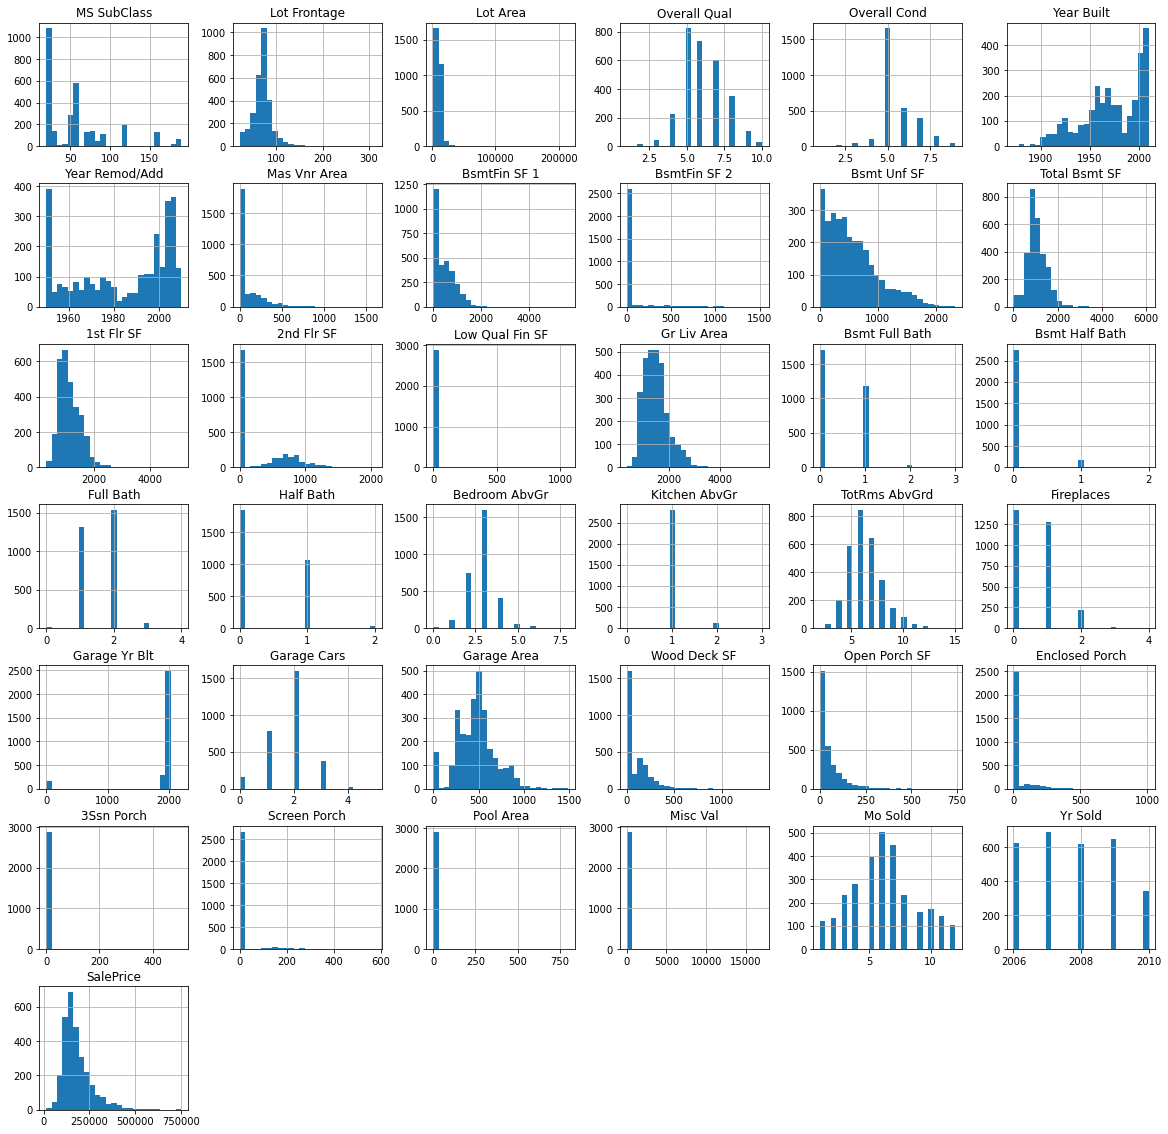

In [15]:
ames_df.hist(figsize=(20, 20), bins=25);

We can see that some features and the target have large values and others are skewed, so we will standardized them to help improve the performance of our models.

<a id='1.2'></a>
## <u> 1.2 Standardization

it's essential to stantardize the numerical features to prevent those with larger ranges from having a disproportionate influence on the model.

In [16]:
num_vars=ames_df.select_dtypes(include=["float64","int64"]).columns
num_vars=num_vars.drop("SalePrice")

ames_df[num_vars]=StandardScaler().fit_transform(ames_df[num_vars])

display(ames_df)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,-0.876479,RL,3.365999,2.743389,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.448585,1.677886,WD,Normal,215000
1,-0.876479,RH,0.505116,0.186969,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.358371,-0.10317,1.853754,-0.063053,-0.089453,-0.080154,1.677886,WD,Normal,105000
2,-0.876479,RL,0.552016,0.522572,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,-0.358371,-0.10317,-0.285460,-0.063053,21.978219,-0.080154,1.677886,WD,Normal,172000
3,-0.876479,RL,1.114813,0.128350,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.817016,1.677886,WD,Normal,244000
4,0.061550,RL,0.223718,0.467125,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-1.185447,1.677886,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.530564,RL,-1.511572,-0.280591,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-1.185447,-1.359894,WD,Normal,142500
2926,-0.876479,RL,-0.000247,-0.160307,Pave,IR1,Low,AllPub,Inside,Mod,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.080154,-1.359894,WD,Normal,131000
2927,0.647818,RL,-0.339079,0.037121,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.358371,-0.10317,-0.285460,-0.063053,1.146337,0.288277,-1.359894,WD,Normal,132000
2928,-0.876479,RL,0.364417,-0.017565,Pave,Reg,Lvl,AllPub,Inside,Mod,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.817016,-1.359894,WD,Normal,170000


<a id='1.3'></a>
## <u> 1.3 Categorical data

Our dataset contains features that range from Poor Quality to Excelent Quality. We will encode such variables by assigning the highest score to 'Excelent' and the lowest score to 'Poor' or 'None'.

In [17]:
ordinal_fts=["Exter Qual","Exter Cond","Bsmt Qual","Bsmt Cond","Heating QC","Kitchen Qual","Fireplace Qu","Garage Qual","Garage Cond"]
ordinal_fts_order=[["Po","Fa","TA","Gd","Ex"],
                    ["Po","Fa","TA","Gd","Ex"],
                    ["None","Po","Fa","TA","Gd","Ex"],
                    ["None","Po","Fa","TA","Gd","Ex"],
                    ["Po","Fa","TA","Gd","Ex"],
                    ["Po","Fa","TA","Gd","Ex"],
                    ["None","Po","Fa","TA","Gd","Ex"],
                    ["None","Po","Fa","TA","Gd","Ex"],
                    ["None","Po","Fa","TA","Gd","Ex"],]

oe=OrdinalEncoder(categories=ordinal_fts_order)
ames_df[ordinal_fts] = oe.fit_transform(ames_df[ordinal_fts])

The remaining categorial features will be encoded using Label Encoder

In [18]:
nominal_fts=["MS Zoning","Street", "Lot Shape","Land Contour","Utilities","Lot Config","Land Slope","Neighborhood","Condition 1","Condition 2",
             "Bldg Type","House Style","Roof Style","Roof Matl","Exterior 1st","Exterior 2nd","Mas Vnr Type","Foundation","Bsmt Exposure",
             "BsmtFin Type 1","BsmtFin Type 2","Heating","Central Air","Electrical","Functional","Garage Type","Garage Finish","Paved Drive",
             "Sale Type","Sale Condition"]

le=LabelEncoder()

for col in nominal_fts:
    ames_df[col]=le.fit_transform(ames_df[col])

display(ames_df)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,-0.876479,5,3.365999,2.743389,1,0,3,0,0,0,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.448585,1.677886,9,4,215000
1,-0.876479,4,0.505116,0.186969,1,3,3,0,4,0,...,-0.358371,-0.10317,1.853754,-0.063053,-0.089453,-0.080154,1.677886,9,4,105000
2,-0.876479,5,0.552016,0.522572,1,0,3,0,0,0,...,-0.358371,-0.10317,-0.285460,-0.063053,21.978219,-0.080154,1.677886,9,4,172000
3,-0.876479,5,1.114813,0.128350,1,3,3,0,0,0,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.817016,1.677886,9,4,244000
4,0.061550,5,0.223718,0.467125,1,0,3,0,4,0,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-1.185447,1.677886,9,4,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.530564,5,-1.511572,-0.280591,1,0,3,0,1,0,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-1.185447,-1.359894,9,4,142500
2926,-0.876479,5,-0.000247,-0.160307,1,0,2,0,4,1,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.080154,-1.359894,9,4,131000
2927,0.647818,5,-0.339079,0.037121,1,3,3,0,4,0,...,-0.358371,-0.10317,-0.285460,-0.063053,1.146337,0.288277,-1.359894,9,4,132000
2928,-0.876479,5,0.364417,-0.017565,1,3,3,0,4,1,...,-0.358371,-0.10317,-0.285460,-0.063053,-0.089453,-0.817016,-1.359894,9,4,170000


<a id='1.4'></a>
## <u> 1.4 Feature relashionships

First we calculate the correlation matrix for all features to see if there's multicollinearity among features in our dataset

In [19]:
corr_mat = ames_df.corr()

# Find pairs of highly correlated features (correlation > 0.85), excluding "SalePrice"
high_corr_pairs = np.where(abs(corr_mat) > 0.85)

high_corr_with_values = [(corr_mat.index[x], corr_mat.columns[y], corr_mat.iloc[x, y]) 
                         for x, y in zip(*high_corr_pairs) 
                         if x != y and x < y and 'SalePrice' not in [corr_mat.index[x], corr_mat.columns[y]]]

# Create a DataFrame to display the results
high_corr_df = pd.DataFrame(high_corr_with_values, columns=['Feature 1', 'Feature 2', 'Correlation Coefficient'])

high_corr_df = high_corr_df.sort_values(by='Correlation Coefficient', ascending=False)

print("Features highly correlated:")
display(high_corr_df)

Features highly correlated:


,Feature 1,Feature 2,Correlation Coefficient
3,Garage Yr Blt,Garage Cond,0.949335
5,Garage Qual,Garage Cond,0.946386
2,Garage Yr Blt,Garage Qual,0.944151
4,Garage Cars,Garage Area,0.889743
0,Exterior 1st,Exterior 2nd,0.865637
1,Fireplaces,Fireplace Qu,0.860060


Multicollinearity negatively affects prediction models by increasing the standard errors of our estimates. To address this we will remove the features that has a weaker correlation with SalePrice.

In [20]:
corr_with_price=corr_mat['SalePrice'].drop('SalePrice')

features_to_drop=[]

for feature1, feature2, corr_value in high_corr_with_values:
    # Compare the correlation of each feature with SalePrice
    corr1=corr_with_price[feature1]
    corr2=corr_with_price[feature2]
    
    # Drop the feature with the weaker correlation with SalePrice
    if abs(corr1)<abs(corr2):
        features_to_drop.append(feature1)
    else:
        features_to_drop.append(feature2)

# Drop the identified features from the dataset
ames_df=ames_df.drop(columns=set(features_to_drop))

print(f"Features dropped: {set(features_to_drop)}")

Features dropped: {'Garage Area', 'Garage Cond', 'Exterior 2nd', 'Garage Yr Blt', 'Fireplaces'}


Then we plot the correlation heatmap for features with |correlation between feature and saleprice|>0.5

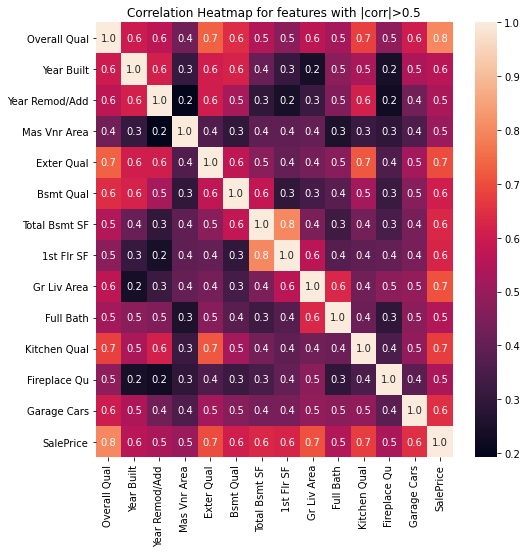

In [21]:
corr_mat=ames_df.corr()["SalePrice"]
high_corr=corr_mat[corr_mat>=0.5].index.to_list()

plt.figure(figsize=(8,8));
sns.heatmap(ames_df[high_corr].corr(), annot=True,fmt=".1f");
plt.title('Correlation Heatmap for features with |corr|>0.5');

Now we plot the scatterplot for the most correlated features (vs SalePrice):

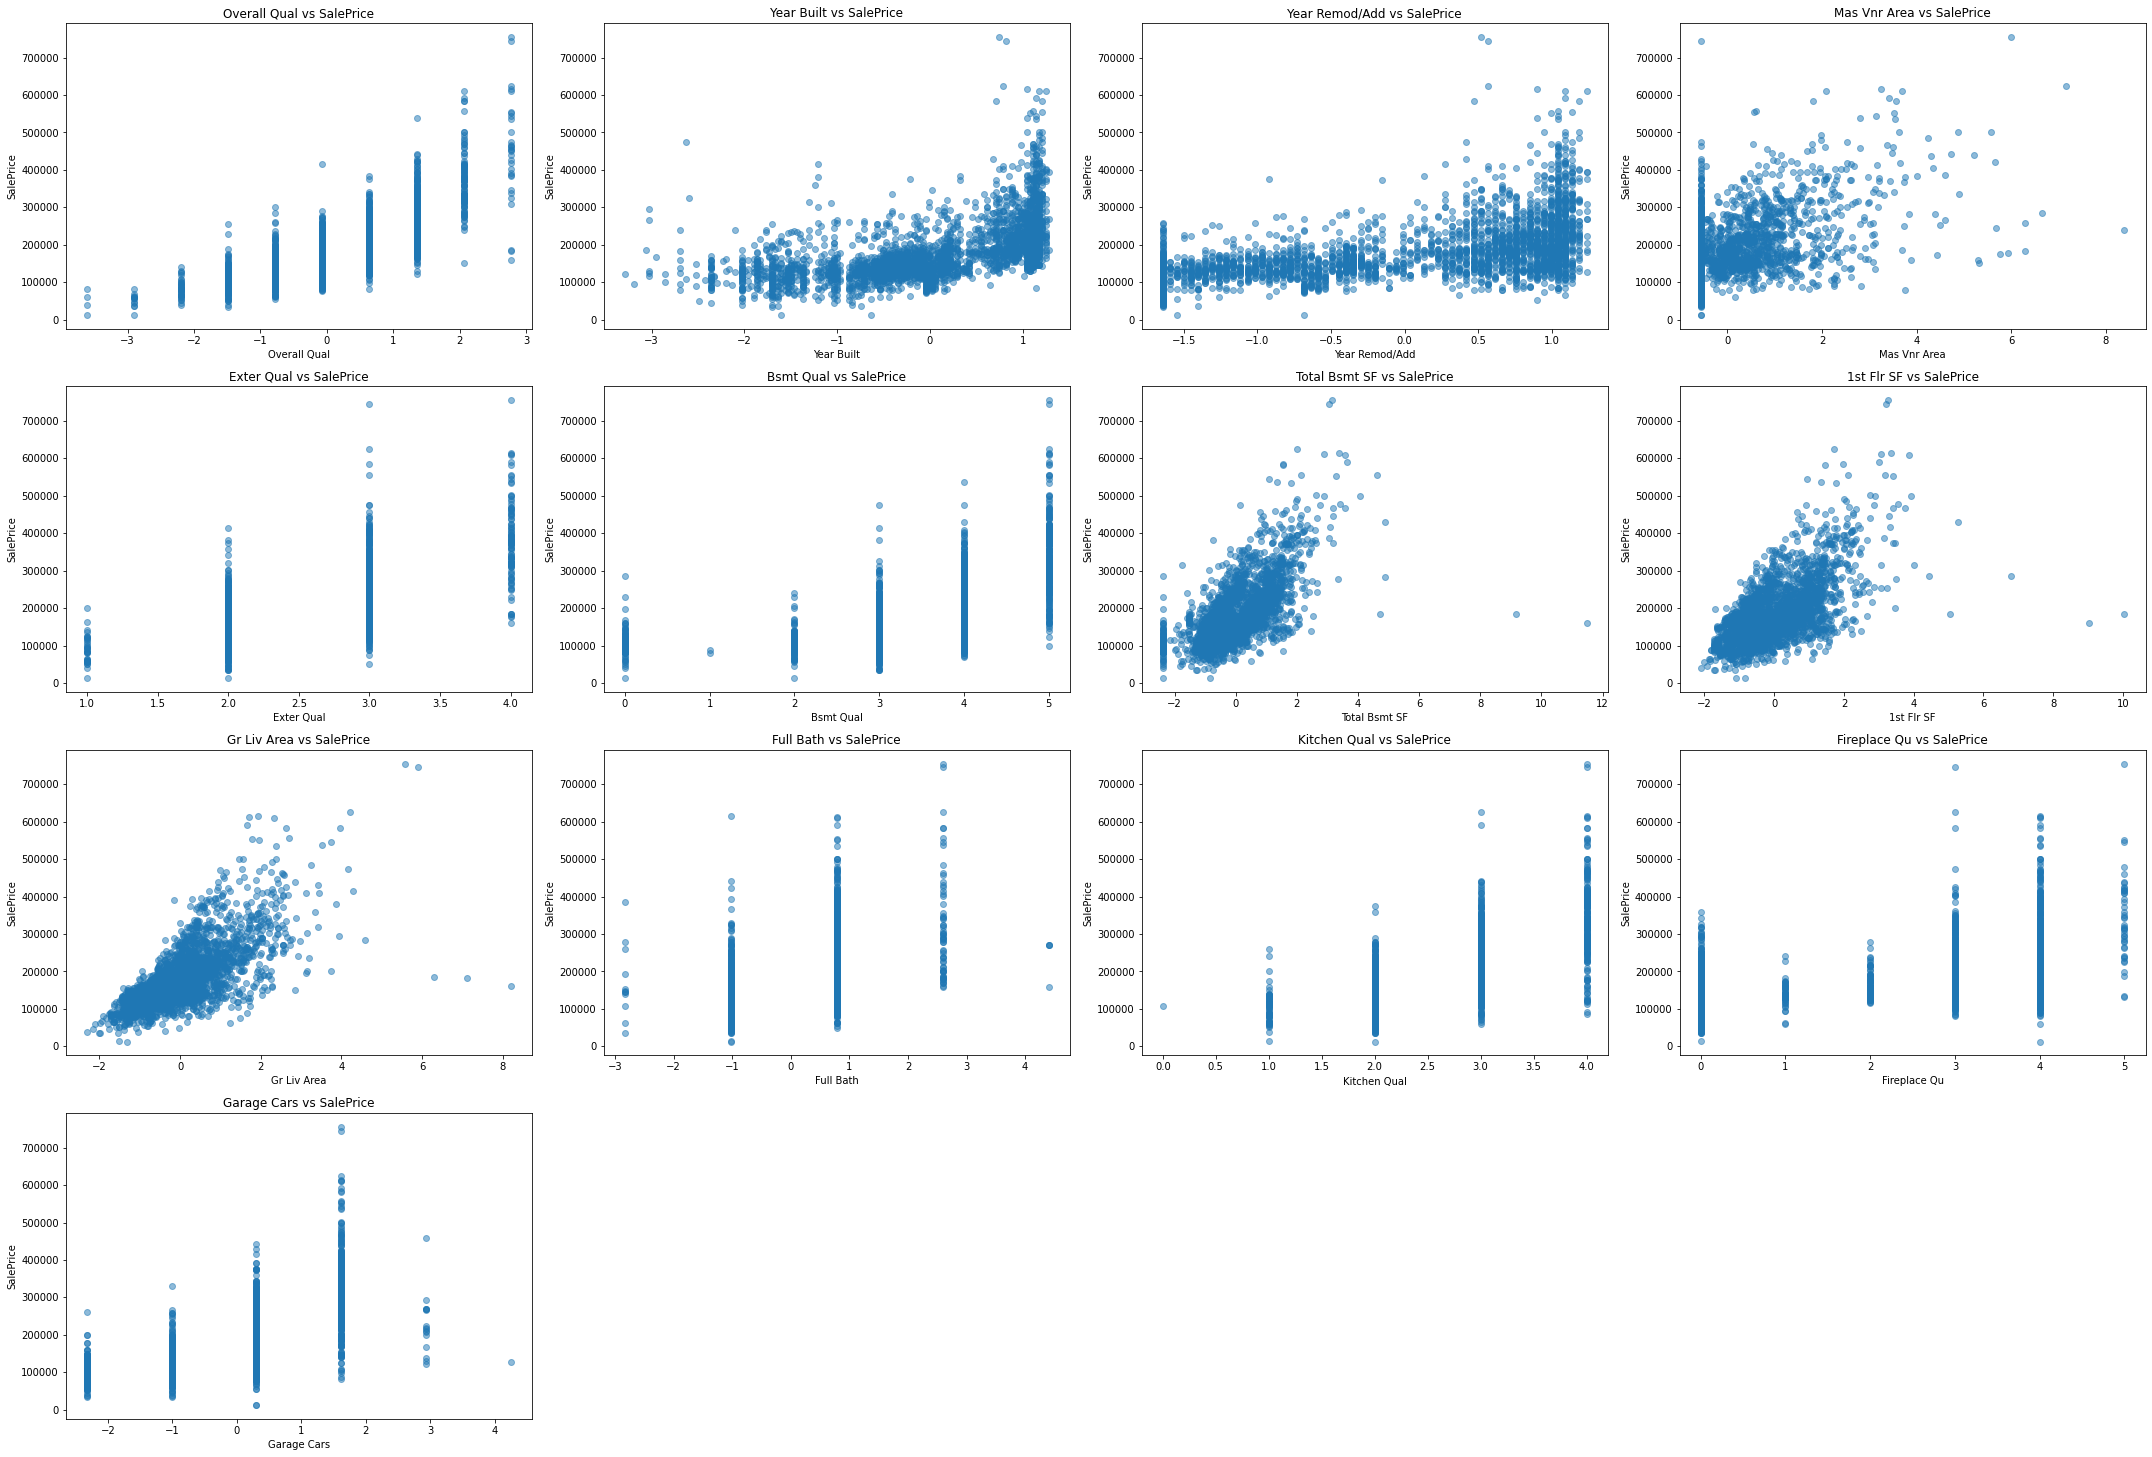

In [22]:
plt.figure(figsize=(30,30));

if "SalePrice" in high_corr:
    high_corr.remove("SalePrice")

for i, col in enumerate(high_corr, 1):
    plt.subplot(6, 4, i) 
    plt.scatter(ames_df[col], ames_df['SalePrice'], alpha=0.5)
    plt.title(f'{col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel('SalePrice')

plt.tight_layout()
plt.show()

In the scatterplots we can see some outliers in the graphs GrLivArea and TotalBsmtSF vs Saleprice (Large Area/BsmtSF vs Low Sale Price), hence we will remove data with SalePrice<200,000 and GrLivArea > 4.5 and also those with SalePrice<r00,000 and GrLivArea > 6

In [23]:
ames_df=ames_df.drop(ames_df[(ames_df["SalePrice"] < 200000) & (ames_df["Gr Liv Area"] > 4.5)].index, axis=0)
ames_df=ames_df.drop(ames_df[(ames_df["SalePrice"] < 400000) & (ames_df["1st Flr SF"] > 6)].index, axis=0)

<a id='1.5'></a>
## <u> 1.5 Sales price 

We Compare using the Sales Price and a log-transform of the Sales Price.

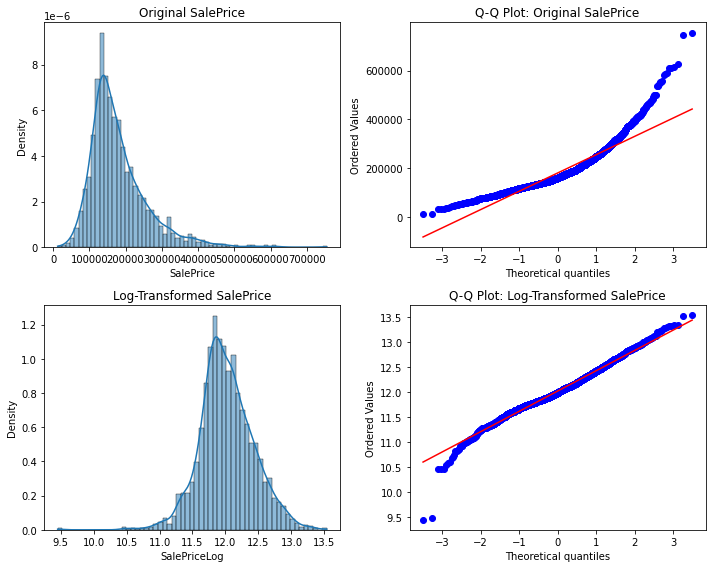

In [24]:
fig,axs=plt.subplots(2, 2, figsize=(10, 8))

#Original SalePrice
sns.histplot(ames_df['SalePrice'], kde=True, stat="density", line_kws={'label': 'Normal distribution fit'}, ax=axs[0, 0])
axs[0, 0].set_title('Original SalePrice')

stats.probplot(ames_df['SalePrice'], plot=axs[0, 1])
axs[0, 1].set_title('Q-Q Plot: Original SalePrice')

# Log transform SalePrice
ames_df['SalePriceLog'] = np.log(ames_df['SalePrice'])

sns.histplot(ames_df['SalePriceLog'], kde=True, stat="density", line_kws={'label': 'Normal distribution fit'}, ax=axs[1, 0])
axs[1, 0].set_title('Log-Transformed SalePrice')

stats.probplot(ames_df['SalePriceLog'], plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot: Log-Transformed SalePrice')

plt.tight_layout()
plt.show()


We can see that the original "SalePrice" has a skewed distribution, which can decline the model performance. When we apply a log transformation, the kurtosis is reduced, which could help improve the model performance.

<a id='2'></a>
# <u> 2. Machine Learning

First we perform an 80:20 train test split:

In [25]:
X=ames_df.drop(['SalePrice','SalePriceLog'],axis=1)
y=ames_df['SalePriceLog']

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.20, random_state=970217)

<a id='2.1'></a>
## <u> 2.1 Linear regression

We will perform a linear regression using both RIDGE and LASSO regularization.
We create some helper functions to evaluate the metrics of the model and to plot the residuals and the predicted values

In [26]:
#Function to evaluate and display R2, MSE, and RMSE
def evaluate_model(model, y_test, y_pred,best_alpha):
    mse=mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(mse)
    r_squared=r2_score(y_test, y_pred)
    
    metrics_df = pd.DataFrame({
        'Model': [model],
        'R-squared (R2)': [r_squared],
        'MSE': [f"{mse:,.2f}"],
        'RMSE': [f"{rmse:,.2f}"],
        'alpha':[best_alpha]
    })
    
    # Display the DataFrame to the user
    display(metrics_df)

#Function to format the axis labels to display values in thousands
def thousands_formatter(x, pos):
    return f'{int(x/1000):,}K'

#Function to plot residuals and predicted values
def plot_scatter(y_pred, y_test, residuals, model_name):
    plt.figure(figsize=(12, 5))

    #Predicted vs Residuals plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'{model_name}: Predicted vs Residuals', fontsize=14)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.grid(True)

    #Predicted vs Actual plot
    plt.subplot(1, 2, 2)
    sns.regplot(x=y_pred, y=y_test, color='green', line_kws={'color':'red'})
    plt.title(f'{model_name}: Predicted vs Actual', fontsize=14)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Actual Values', fontsize=12)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#Function to display coefficients of regression
def display_coeff(model_name,model,X_train):
    
    #Get coefficients from model and display how many features it eliminated
    coef=pd.Series(model.coef_, index=X_train.columns)
    print(model_name + " picked " + str(sum(coef!=0)) + " features and eliminated the other " + str(sum(coef==0)) + " features")

    #Create dataframe to display the 25 most relevant coefficients
    coef_df=pd.DataFrame(model.coef_, index=X_train.columns, columns=['Coefficient'])
    coef_df['Magnitude']=abs(coef_df['Coefficient'])
    display(coef_df.sort_values('Magnitude',ascending=False).head(25)[['Coefficient']])


def regression(model,model_name,X_train,y_train,X_test,y_test):

    #Train the model
    model.fit(X_train,y_train)
    
    #Get the best alpha (regularization parameter)
    best_alpha=model.alpha_

    #Make predictions in log-scale
    y_pred_log=model.predict(X_test)

    #Revert predictions to original scale by applying exponential function
    y_pred=np.exp(y_pred_log)
    y_test_original=np.exp(y_test)

    #Evaluate model performance
    evaluate_model(model_name,y_test_original,y_pred,best_alpha)
    residuals=y_test_original-y_pred

    #Plot scatter plots
    plot_scatter(y_pred, y_test_original, residuals, model_name)

    #Display 25 most relevant features
    display_coeff(model_name,model,X_train)

Ridge regression

,Model,R-squared (R2),MSE,RMSE,alpha
0,Ridge,0.945731,"362,560,102.36","19,041.01",75.167224


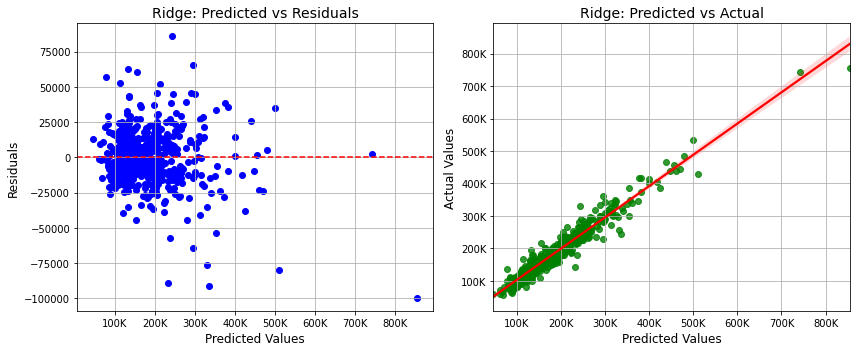

Ridge picked 70 features and eliminated the other 0 features


,Coefficient
Overall Qual,0.089464
Gr Liv Area,0.075922
1st Flr SF,0.056563
Year Built,0.050828
Overall Cond,0.046377
2nd Flr SF,0.038083
Central Air,0.035778
Total Bsmt SF,0.035434
BsmtFin SF 1,0.031702
Paved Drive,0.030844


In [27]:
ridge=RidgeCV(alphas=np.linspace(1, 100, 300))
regression(ridge,"Ridge",X_train,y_train,X_test,y_test)

The Ridge model used all the 75 features, achieved an RMSE of 19 041 and had a high R2, which can explain up to 94.57% of the variance in sale price in the test data.

Lasso regression

,Model,R-squared (R2),MSE,RMSE,alpha
0,Lasso,0.944607,"370,066,727.41","19,237.12",0.001181


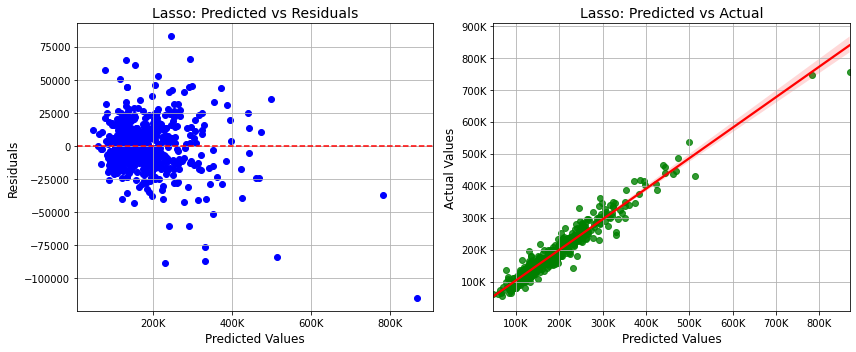

Lasso picked 55 features and eliminated the other 15 features


,Coefficient
Gr Liv Area,0.136645
Overall Qual,0.097046
Year Built,0.061992
Overall Cond,0.048162
Central Air,0.037234
Total Bsmt SF,0.033173
BsmtFin SF 1,0.032629
Sale Condition,0.028043
Paved Drive,0.026757
Kitchen Qual,0.022570


In [28]:
lasso=LassoCV(n_alphas=500)
regression(lasso,"Lasso",X_train,y_train,X_test,y_test)

On the other hand, the Lasso model used 54 features, eliminated 14 features, but achieved a slightly higher RMSE (19 237) than Ridge. Regarding R2, Lasso can explain up to 94.46% of the variance of sale price, which is slightly worse than Ridge but still a good model.

<a id='2.2'></a>
## <u> 2.2 Feature engineering

We will create some new features derived from existing ones. These new features might help improve the model's performance by capturing more relevant information.

1. Total Number of Bathrooms:
   - This feature combines the number of full bathrooms and half bathrooms.
   - Formula:  
   \
   $\text{Total number of Bathrooms}=\text{Full Bathrooms} + 0.5 * (\text{Half Bathrooms})$
   

2. Age of the House When Sold:
   - This feature calculates the age of the house at the time of sale, by subtracting the year it was built from the year it was sold.
   - **Formula**:  
   \
   $\text{Age of the House}=\text{Year Sold} - \text{Year Built}$
   

3. Total area of the house:
   - This feature calculates the total area of the house by combining the total basement area and the total area above ground
   - Formula:  
   \
   $\text{Total Area}=\text{Total Basement SF} + \text{Gr Liv Area}$




In [29]:
ames_df['totalBathrooms'] = ames_df["Full Bath"] + ames_df["Bsmt Full Bath"] + 0.5 * (ames_df["Half Bath"] + ames_df["Bsmt Half Bath"])
ames_df['houseAge'] = ames_df["Yr Sold"] - ames_df["Year Built"]
ames_df['totalArea'] = ames_df["Total Bsmt SF"] - ames_df["Gr Liv Area"]


In [30]:
X_newft=ames_df.drop(['SalePrice','SalePriceLog'],axis=1)
y_newft=ames_df['SalePriceLog']

X_newft_train,X_newft_test,y_newft_train,y_newft_test=train_test_split(X_newft, y_newft, test_size=0.20, random_state=970217)

,Model,R-squared (R2),MSE,RMSE,alpha
0,Ridge,0.945668,"362,982,955.77","19,052.11",84.769231


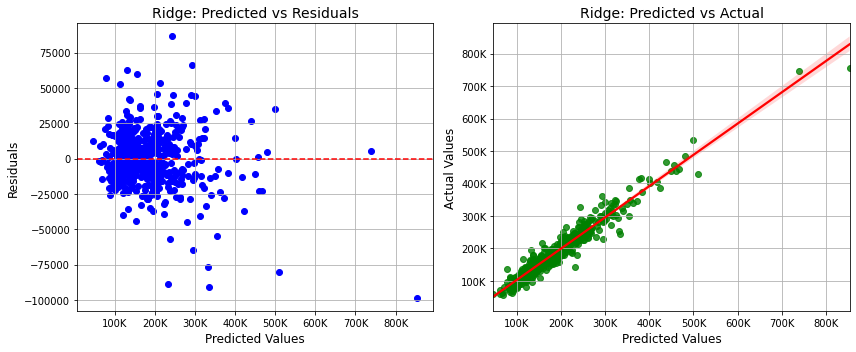

Ridge picked 73 features and eliminated the other 0 features


,Coefficient
Overall Qual,0.088389
Gr Liv Area,0.065998
1st Flr SF,0.051780
Overall Cond,0.046762
Total Bsmt SF,0.046508
BsmtFin SF 1,0.036428
Central Air,0.033800
Year Built,0.033050
2nd Flr SF,0.030822
Paved Drive,0.029867


In [31]:
#We fit Ridge again to the "enhanced" data set

ridge=RidgeCV(alphas=np.linspace(1, 100, 300))
regression(ridge,"Ridge",X_newft_train,y_newft_train,X_newft_test,y_newft_test)

We see that the original Ridge model perfoms slightly better than the model with the new features

| Model         | MSE         | RMSE       | R-squared |
|---------------|-------------|------------|-----------|
| Ridge Original| 362,560,102.36 | 19,041.01   | 0.9457      |
| Ridge New features| 362,982,955.77 | 19,052.11  | 0.9456      |


,Model,R-squared (R2),MSE,RMSE,alpha
0,Lasso,0.943863,"375,040,856.93","19,365.97",0.001283


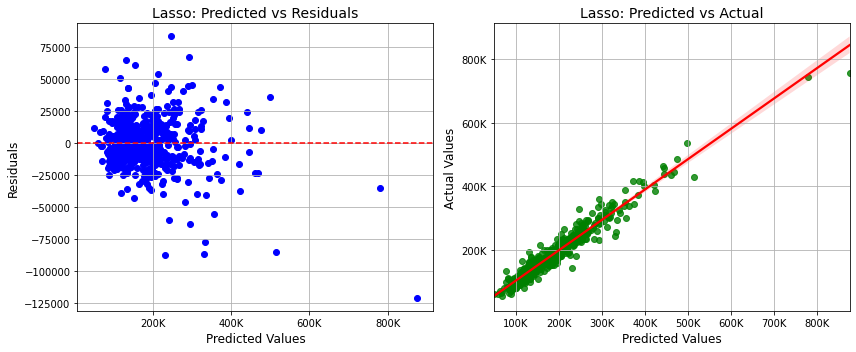

Lasso picked 53 features and eliminated the other 20 features


,Coefficient
Gr Liv Area,0.134168
Overall Qual,0.097238
Year Built,0.052392
Overall Cond,0.048087
Central Air,0.035299
Total Bsmt SF,0.033555
BsmtFin SF 1,0.031674
Sale Condition,0.027995
Paved Drive,0.026821
Kitchen Qual,0.022852


In [32]:
#Now fit Lasso again to the "enhanced" data set
lasso=LassoCV(n_alphas=500)
regression(lasso,"Lasso",X_newft_train,y_newft_train,X_newft_test,y_newft_test)

The Lasso model, similar to the Ridge model, performs better when using the original features:

| Model         | MSE         | RMSE       | R-squared |
|---------------|-------------|------------|-----------|
| Lasso Original| 370,066,727.41 | 19,237.12   | 0.9446      |
| Lasso New features| 375,040,856.93 | 19,365.97  | 0.9438      |

<a id='3'></a>
# <u> 3. Conclusion and Feature Importance

We have already conducted feature selection by removing features that were highly correlated with each other to reduce collinearity. Also, as we already saw in our results, the Lasso model imposes zero coefficients to those features that have little importance. Now, we can apply the Recursive Feature Elimination (RFE) algorithm to determine if it further improves the model's performance.

In [33]:
# Initialize RFE with the Ridge model and set the number of features to select
rfe = RFE(estimator=ridge, n_features_to_select=53)

rfe.fit(X_train, y_train)

# Select features
selected_features = X.columns[rfe.support_]
print("Selected features by RFE with Ridge:")
print(selected_features)

# Make predictions
y_pred_ridge_rfe = np.exp(rfe.predict(X_test))
y_test_original = np.exp(y_test)

# Evaluate the model
mse_rfe_ridge = mean_squared_error(y_test_original, y_pred_ridge_rfe)
rmse_rfe_ridge = np.sqrt(mse_rfe_ridge)
r2_rfe_ridge = r2_score(y_test_original, y_pred_ridge_rfe)

# Print evaluation metrics
print(f"MSE: {mse_rfe_ridge:.2f}")
print(f"RMSE: {rmse_rfe_ridge:.2f}")
print(f"R-squared: {r2_rfe_ridge:.5f}")


Selected features by RFE with Ridge:
Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Land Slope', 'Bldg Type',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplace Qu',
       'Garage Finish', 'Garage Cars', 'Garage Qual', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch',
       'Yr Sold', 'Sale Condition'],
      dtype='object')
MSE: 361875817.45
RMSE: 19023.03
R-squared: 0.94583


By applying the RFE algorithm with the Ridge model and selecting 53 features (the same number chosen by the Lasso model), we observe an improvement in the model's performance, achieving an R² of 94.58%.

| Model         | MSE         | RMSE       | R-squared |
|---------------|-------------|------------|-----------|
| Ridge Original| 362,560,102.36 | 19,041.01   | 0.9457      |
| Ridge New features| 362,982,955.77 | 19,052.11  | 0.9456      |
| Ridge RFE | 361,875,817.45 | 19,023.03  | 0.9458      |

Now with Lasso:

In [34]:
# Initialize RFE with the Ridge model and set the number of features to select
rfe = RFE(estimator=lasso, n_features_to_select=53)  # You can adjust this number

# Fit RFE
rfe.fit(X_train, y_train)

# Select features
selected_features = X.columns[rfe.support_]
print("Selected features by RFE with Ridge:")
print(selected_features)

# Make predictions
y_pred_lasso_rfe = np.exp(rfe.predict(X_test))
y_test_original = np.exp(y_test)

# Evaluate the model
mse_rfe_lasso = mean_squared_error(y_test_original, y_pred_lasso_rfe)
rmse_rfe_lasso = np.sqrt(mse_rfe_lasso)
r2_rfe_lasso = r2_score(y_test_original, y_pred_lasso_rfe)

# Print evaluation metrics
print(f"MSE: {mse_rfe_lasso:.2f}")
print(f"RMSE: {rmse_rfe_lasso:.2f}")
print(f"R-squared: {r2_rfe_lasso:.5f}")

Selected features by RFE with Ridge:
Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Lot Shape',
       'Land Contour', 'Lot Config', 'Condition 1', 'Bldg Type',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplace Qu',
       'Garage Finish', 'Garage Cars', 'Garage Qual', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch',
       'Yr Sold', 'Sale Type', 'Sale Condition'],
      dtype='object')
MSE: 374736109.51
RMSE: 19358.10
R-sq

In this case, we see that our original Lasso model (without new features) had the best performance, but still slightly worse than our Ridge models

| Model         | MSE         | RMSE       | R-squared |
|---------------|-------------|------------|-----------|
| Lasso Original| 370,066,727.41 | 19,237.12   | 0.9446      |
| Lasso New features| 375,040,856.93 | 19,365.97  | 0.9438      |
| Lasso RFE | 374,729,993.49 | 19,357.94  | 0.9439      |